## opcode, register 빈도수로 학습

In [27]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import glob
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### train set과 test set 합친 후 train_test_split으로 적용

In [16]:
# train_benign 데이터프레임화 하기
import pandas as pd
train_benign_df = pd.read_csv("./csv_files/train_benign_asmfile.txt")
train_benign_df.drop(train_benign_df.columns[-1], axis=1, inplace=True)
train_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_benign_df['label'] = 0
train_benign_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,4d1bbe1ef6371b338826836d740d726f,2473,25391,0,11703,3486,2544,1724,25,1304,...,0,0,0,0,0,0,2,367,113,0
1,0d2b28bec8d17f692db56e87cce59992,520,4692,0,5653,1239,453,520,0,274,...,0,0,0,1,1,0,7,0,17,0
2,4df4d08911a65aa83284545ca1ffeb71,294,2016,0,2579,711,348,271,6,165,...,0,0,0,0,0,0,7,0,7,0
3,1ed70ce407ad8203816829b4ea1aae3d,289,1306,0,1992,170,127,77,0,88,...,0,0,0,0,0,0,0,0,0,0
4,2eccffbe627068a60bf7911fd8701ae6,143,1165,0,1107,266,124,159,0,48,...,0,0,0,0,0,0,2,0,0,0


In [17]:
# train_malware 데이터프레임화 하기
train_malware_df = pd.read_csv("./csv_files/train_malware_asmfile.txt")
train_malware_df.drop(train_malware_df.columns[-1], axis=1, inplace=True)
train_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_malware_df['label'] = 1
train_malware_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,1e83041702d866316703a77fcacb558a,86,471,0,248,73,74,64,0,26,...,0,0,0,0,0,0,0,84,0,1
1,2ef324ee0b6960d7e5bc6425b9523b19,280,1387,0,2012,169,127,78,0,111,...,0,0,0,0,0,0,0,0,0,1
2,3c7fc3a1a687f0c303a0e0944e59e5df,1180,15749,1,11070,6019,1326,2152,154,816,...,0,0,0,0,0,0,0,56,7,1
3,3e0d176812b1416f4e399ebe35ba9ca2,82,335,2,689,12,7,9,0,27,...,0,0,0,0,0,0,0,0,0,1
4,2bd568265b715c5b6c056ba79b745869,119,1195,0,368,44,53,30,0,85,...,0,0,0,0,0,0,1,0,0,1


In [18]:
# test_benign 데이터프레임화 하기
test_benign_df = pd.read_csv("./csv_files/test_benign_asmfile.txt")
test_benign_df.drop(test_benign_df.columns[-1], axis=1, inplace=True)
test_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_benign_df['label'] = 0
test_benign_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,81d7090453f6ff1002c527770ca07146,3944,33801,0,18811,2585,1371,2681,0,1249,...,0,0,0,0,0,0,27,4,0,0
1,55c1c08c57978b7bb53627770d412927,269,3169,0,2591,827,301,380,12,183,...,0,0,0,0,0,0,5,19,30,0
2,63d81adeb6249f46afafda55e6e93039,1109,12923,0,5725,1324,681,710,8,360,...,0,0,0,0,0,0,7,242,13,0
3,65c3e172c54b1c4314c24bfe503c3fe8,11275,219706,77,147356,3269,1111,2273,12,5921,...,0,0,0,0,0,0,3,0,0,0
4,86a72d942afb48d1f67116dcc7b592b7,375,3552,0,153,230,168,131,6,321,...,0,0,0,0,0,0,2,0,99,0


In [19]:
# test_malware 데이터프레임화 하기
test_malware_df = pd.read_csv("./csv_files/test_malware_asmfile.txt")
test_malware_df.drop(test_malware_df.columns[-1], axis=1, inplace=True)
test_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
test_malware_df['label'] = 1
test_malware_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,5c5388a7e69307e5fc797950be4f5834,264,4476,0,1174,621,376,279,10,413,...,0,0,0,0,0,0,0,7,80,1
1,5cb2bc5ad7d1bd564d60ecd6bba54e1e,629,4487,5,2741,1041,546,356,2,321,...,0,0,0,0,0,0,1,0,0,1
2,4f25536d08b521ba01609780d8f35f8f,27,387,0,423,79,39,32,0,31,...,0,0,0,0,0,0,8,4,0,1
3,5cda903fa66b514f7ef7ac0018c859a3,75,1634,0,1456,205,131,51,63,68,...,0,0,0,0,0,0,63,0,0,1
4,5ca6ff3598d0396cbed067c813dd5538,38,516,61,97,43,18,101,1,34,...,0,0,0,0,0,0,0,0,0,1


In [20]:
import sklearn
train_df = pd.concat([train_benign_df, train_malware_df], axis=0, ignore_index=True)
test_df = pd.concat([test_benign_df, test_malware_df], axis=0, ignore_index=True)
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_shuffled_df = sklearn.utils.shuffle(full_df)
full_shuffled_df

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
173,6cb20cd7f07eb7bbda2c3908362e6434,325,6238,0,2494,706,431,289,8,302,...,0,0,0,0,0,0,0,0,29,0
478,3ce411b120a9950d4f689ce518974bb1,915,16167,0,8774,3149,1183,1586,132,773,...,0,0,0,0,0,0,2,0,8,0
854,2b3dc844dfb6f058c608b186bcfcec95,9505,129747,0,46052,23097,7731,9194,1550,5604,...,0,0,0,0,0,0,0,840,29,0
1814,3ee2cabacc1fe14410da3d6b78151b9f,264,4476,0,1174,621,376,279,10,413,...,0,0,0,0,0,0,0,7,80,1
2383,4ff6aea4fa1be90cdf69ed03468a4858,10,75,0,303,30,20,18,0,10,...,0,0,0,0,0,0,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,3b46d46a5e1476f458b354df4d83c556,26,99,0,439,20,12,35,1,12,...,0,0,0,0,0,0,0,0,0,1
790,2b568c09db5191980c82335541cd0d41,1190,8318,0,5239,774,369,624,181,324,...,0,0,0,0,0,0,0,0,0,0
1691,3b51e05077a7c99dac6325b383f4f364,694,48548,7,91267,559,166,365,1,481,...,0,0,0,0,0,0,1,0,0,1
876,5b1f26a32a5c188bd4b2c45c3e750d24,730,4753,0,4505,793,537,454,0,311,...,0,0,0,0,0,0,3,0,0,0


### validation set 처리

In [22]:
#  valid_benign 데이터프레임화 하기
valid_benign = pd.read_csv("./csv_files/valid_benign_asmfile.txt")
valid_benign.drop(valid_benign.columns[-1], axis=1, inplace=True)
valid_benign.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_benign['label'] = 0
valid_benign.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,36d0fd2c3cfec5e4c79623115bab7650,32,164,0,201,11,14,8,0,5,...,0,0,0,0,0,0,0,0,0,0
1,51ebb12e96ccb69d1f46ab0c9ccbdbfe,2652,40446,0,16233,5679,2350,2178,73,1091,...,0,0,0,0,0,0,0,1,15,0
2,34bc42dd84bb7f0d5f068d62d8fe0775,39,367,0,247,57,11,12,0,23,...,0,0,0,0,0,0,0,0,0,0
3,41e4891951b3768985d9d4228d0c90f1,34,334,0,257,166,77,57,0,10,...,0,0,0,0,0,0,0,0,0,0
4,46b6ecb93d00703b93cf435af82ad601,144,1005,0,611,142,104,70,1,68,...,0,0,0,0,0,0,0,358,0,0


In [23]:
# valid_malware 데이터 프레임화 하기
valid_malware = pd.read_csv("./csv_files/valid_malware_asmfile.txt")
valid_malware.drop(valid_malware.columns[-1], axis=1, inplace=True)
valid_malware.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
valid_malware['label'] = 1
valid_malware.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,4bdd8f1ff95b78a976c063edf36d1c35,372,4884,0,2422,176,185,166,0,230,...,0,0,0,0,0,0,0,0,62,1
1,4bb10461e03ce503caa38d9b6bceb114,264,4476,0,1174,621,376,279,10,413,...,0,0,0,0,0,0,0,7,80,1
2,4cafa405cac9ee9af5fb8422cb68c999,68,312,6,410,21,2,18,0,19,...,0,0,0,0,0,0,2,0,0,1
3,4c96ae5fd77191fc72661c28e14aa087,2357,37536,1,11163,3286,5587,1395,324,4080,...,0,0,0,0,0,0,184,23,666,1
4,4cee3a697cbf342ea219f6c54f864419,998,10986,4,8391,399,161,276,0,567,...,0,0,0,0,0,0,53,0,0,1


In [24]:
train_df = pd.concat([full_df, valid_benign], axis=0, ignore_index=True)
test_df = pd.concat([full_df, valid_malware], axis=0, ignore_index=True)
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_shuffled_df = sklearn.utils.shuffle(full_df)
full_shuffled_df

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
4489,2b258f73b5be13653ffa4ec4c32232ec,43,689,0,1304,323,110,113,24,52,...,0,0,0,0,0,0,6,0,0,1
1586,2e031d0af0326cd10c7690d744b318cd,146,2702,0,2374,411,708,138,6,144,...,0,0,0,0,0,0,0,0,0,1
3989,3d42b0f9d18952a8e9b3db2ddd8711dc,1276,16656,22,12002,6582,1540,2147,162,950,...,0,0,0,0,0,0,0,56,29,1
89,2d01f89d7770ca3ebfbb1ba5b75951bb,77,564,0,709,107,40,28,0,52,...,0,0,0,0,0,0,1,0,0,0
1587,2ceacef73ed1d018054a4f0ca618f4a6,871,1539,17,595,19,6,274,1,13,...,0,0,0,0,0,0,83,0,288,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269,4d9cbf10a5eb25b998fe000828c8ef31,5270,31771,2,38839,6283,2783,2589,11,2952,...,0,0,0,0,0,0,6,0,82,0
1867,3e67417666d55eb1abc538b9fb97b4ee,5404,61677,0,40644,15147,7155,5017,350,3511,...,0,0,0,8,0,0,10,374,523,1
885,5e522223f681fe8f13e83628bc95a951,1963,13966,0,12775,2182,672,1288,0,542,...,0,0,0,0,0,0,1,7,4,0
3733,2ca6ba7a9e5e350d88e95a60d6817540,571,7030,0,5140,1176,588,401,0,468,...,0,0,0,0,0,0,57,18,45,1


### 정규화

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
NORMALIZE_VALID_COLUMNS = [ 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword']

full_shuffled_df[NORMALIZE_VALID_COLUMNS] = scaler.fit_transform(full_shuffled_df[NORMALIZE_VALID_COLUMNS])
full_shuffled_df[NORMALIZE_VALID_COLUMNS].astype('float')
full_shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5190 entries, 4489 to 440
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      5190 non-null   object 
 1   jmp     5190 non-null   float64
 2   mov     5190 non-null   float64
 3   retf    5190 non-null   float64
 4   push    5190 non-null   float64
 5   pop     5190 non-null   float64
 6   xor     5190 non-null   float64
 7   retn    5190 non-null   float64
 8   nop     5190 non-null   float64
 9   sub     5190 non-null   float64
 10  inc     5190 non-null   float64
 11  dec     5190 non-null   float64
 12  add     5190 non-null   float64
 13  imul    5190 non-null   float64
 14  xchg    5190 non-null   float64
 15  or      5190 non-null   float64
 16  shr     5190 non-null   float64
 17  cmp     5190 non-null   float64
 18  call    5190 non-null   float64
 19  shl     5190 non-null   float64
 20  ror     5190 non-null   float64
 21  rol     5190 non-null   float64
 22

###  label값 개수를 동일하게 하기 위한 교차검증 사용 (stratifiedKFold)

#### DecisionTree Classifier

In [40]:
from sklearn.model_selection import StratifiedKFold

# decision tree 모델 생성
dt_clf = DecisionTreeClassifier(random_state= 10)

features = full_shuffled_df[NORMALIZE_VALID_COLUMNS]
label = full_shuffled_df['label']
skf = StratifiedKFold(n_splits=2)
n_iter = 0

for train_index, test_index in skf.split(features, label):
  n_iter += 1
  label_train = label.iloc[train_index]
  label_test = label.iloc[test_index]
  X_train, X_test = features.iloc[list(train_index)], features.iloc[list(test_index)]
  y_train, y_test = label.iloc[list(train_index)], label.iloc[list(test_index)]
  dt_clf.fit(X_train, y_train)
  print('------------ 교차 검증 ------------ : {}'.format(n_iter))  
  print('교차 검증 정확도 : {}'.format(accuracy_score(y_test, dt_clf.predict(X_test))))
  print('학습 레이블(label_train) 데이터 분포 : \n', label_train.value_counts())
  print('검증 레이블(label_train) 데이터 분포 : \n', label_test.value_counts())
  print('\n')

------------ 교차 검증 ------------ : 1
교차 검증 정확도 : 0.9387283236994219
학습 레이블(label_train) 데이터 분포 : 
 0    1298
1    1297
Name: label, dtype: int64
검증 레이블(label_train) 데이터 분포 : 
 1    1298
0    1297
Name: label, dtype: int64


------------ 교차 검증 ------------ : 2
교차 검증 정확도 : 0.933718689788054
학습 레이블(label_train) 데이터 분포 : 
 1    1298
0    1297
Name: label, dtype: int64
검증 레이블(label_train) 데이터 분포 : 
 0    1298
1    1297
Name: label, dtype: int64




### 주성분검출(PCA)

In [66]:
from sklearn.decomposition import PCA

skpca = PCA(n_components=30)
X_pca = skpca.fit_transform(X_train)
print('Variance sum : ', skpca.explained_variance_ratio_.cumsum()[-1])

Variance sum :  0.9988063585376175


### RandomForestClassifier

In [67]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report, confusion_matrix

model = RFC(n_estimators=100, random_state=0, 
                          oob_score = True,
                          max_depth = 16, 
                          max_features = 'sqrt')

model.fit(X_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
X_test_pca = skpca.transform(X_test_new)

y_pred = model.predict(X_test_pca)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1298
           1       0.97      0.95      0.96      1297

    accuracy                           0.96      2595
   macro avg       0.96      0.96      0.96      2595
weighted avg       0.96      0.96      0.96      2595



In [64]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report, confusion_matrix

model = RFC(n_estimators=100, random_state=0, 
                          oob_score = True,
                          max_depth = 16, 
                          max_features = 'sqrt')

features = full_shuffled_df[NORMALIZE_VALID_COLUMNS]
label = full_shuffled_df['label']
skf = StratifiedKFold(n_splits=2)
n_iter = 0

X_test_scaled = scaler.transform(X_test)
X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
X_test_pca = skpca.transform(X_test_new)

for train_index, test_index in skf.split(features, label):
  n_iter += 1
  label_train = label.iloc[train_index]
  label_test = label.iloc[test_index]
  X_pca, X_test_pca = features.iloc[list(train_index)], features.iloc[list(test_index)]
  y_train, y_test = label.iloc[list(train_index)], label.iloc[list(test_index)]
  model.fit(X_pca, y_train)
  print('------------ 교차 검증 ------------ : {}'.format(n_iter))  
  print('교차 검증 정확도 : {}'.format(accuracy_score(y_test, model.predict(X_test_pca))))
  print('학습 레이블(label_train) 데이터 분포 : \n', label_train.value_counts())
  print('검증 레이블(label_train) 데이터 분포 : \n', label_test.value_counts())
  print('\n')


------------ 교차 검증 ------------ : 1
교차 검증 정확도 : 0.9495183044315992
학습 레이블(label_train) 데이터 분포 : 
 0    1298
1    1297
Name: label, dtype: int64
검증 레이블(label_train) 데이터 분포 : 
 1    1298
0    1297
Name: label, dtype: int64


------------ 교차 검증 ------------ : 2
교차 검증 정확도 : 0.9672447013487476
학습 레이블(label_train) 데이터 분포 : 
 1    1298
0    1297
Name: label, dtype: int64
검증 레이블(label_train) 데이터 분포 : 
 0    1298
1    1297
Name: label, dtype: int64




<AxesSubplot:>

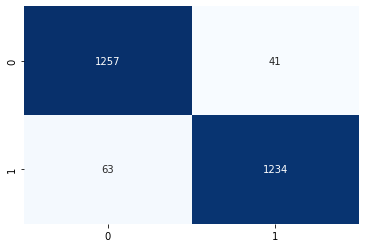

In [45]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### Support Vector Machine

In [46]:
from sklearn.svm import SVC

In [47]:
model = SVC()

In [48]:
model.fit(X_pca,y_train)

SVC()

In [49]:
predictions = model.predict(X_test_pca)

In [50]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.40      0.54      1298
           1       0.60      0.91      0.73      1297

    accuracy                           0.66      2595
   macro avg       0.71      0.66      0.63      2595
weighted avg       0.71      0.66      0.63      2595



<AxesSubplot:>

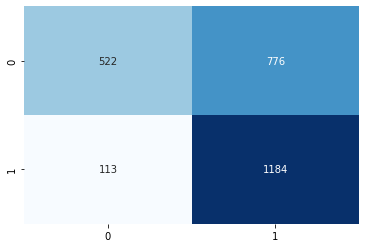

In [51]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False)

### 하이퍼 파라미터 search (GridSearchCV)

In [53]:
from sklearn.model_selection import GridSearchCV

In [71]:
params = { 'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80],
           'max_depth' : [14, 16, 18, 20, 22],
           'min_samples_leaf' : [2, 3, 4],
           'min_samples_split' : [1, 2, 3, 4]
            }

In [72]:
# model = RFC(n_estimators=100, random_state=0, 
#                           oob_score = True,
#                           max_depth = 16, 
#                           max_features = 'sqrt')

# model.fit(X_pca, y_train)

# X_test_scaled = scaler.transform(X_test)
# X_test_new = pd.DataFrame(X_test_scaled, columns=features.columns)
# X_test_pca = skpca.transform(X_test_new)

# y_pred = model.predict(X_test_pca)
# print(classification_report(y_test,y_pred))

hipher_rf_clf = RandomForestClassifier(random_state=0, n_jobs = -1, max_features = 'sqrt')
grid_cv = GridSearchCV(hipher_rf_clf, params, cv = 5, n_jobs=-1)
grid_cv.fit(X_pca, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도 : {:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:  {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}
최고 예측 정확도 : 0.9445


In [76]:
rf_best = RandomForestClassifier(n_estimators=40,
                                 max_depth=18,
                                 min_samples_leaf=2,
                                 min_samples_split=2,
                                 random_state=0,
                                 n_jobs=-1)
rf_best.fit(X_pca, y_train)

pred = rf_best.predict(X_test_pca)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1298
           1       0.97      0.95      0.96      1297

    accuracy                           0.96      2595
   macro avg       0.96      0.96      0.96      2595
weighted avg       0.96      0.96      0.96      2595



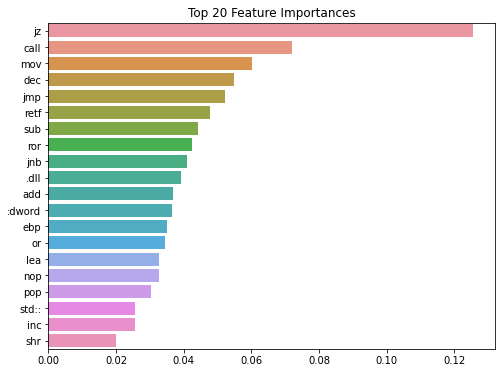

In [79]:
ftr_importances_values = dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()